In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from typing import List, Dict, Set, Union, Any
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [2]:
def read_log_or_subgroup(csv_file: str) -> Dict[str, List[str] ]:
    """
        Reader for train / val csv.
        Return: Dict[user_id] = List[ course_id | subgroup ]
    """
    res = {}
    with open(csv_file) as f:
        columns = f.readline().strip().split(',')
        assert ( len(columns) == 2 and columns[0] == 'user_id' and columns[1] in ['course_id', 'subgroup'] )
        for line in f.readlines():
            data = line.strip().split(',')
            assert( len(data) == len(columns) )
            res[data[0]] = data[1].split(' ')
        
        if columns[1] == 'subgroup':
            for key, value in res.items():
                if len(value) == 1 and value[0] == '':
                    res[key]  = []
                else:
                    res[key] = [ int(x) for x in value ]
    return res

In [3]:
def read_csv_as_dict( csv_file: str, key_index: int = 0, value_type = dict) -> Dict[ str, Union[Dict,List] ]:
    assert( value_type in [dict, Dict, list, List] )
    df = pd.read_csv(csv_file)
    keys = list(df.keys())
    key, others = keys.pop(key_index), keys
    
    data_dict = {}
    for data in df.iloc:
        data_dict[ data[key] ] = dict(data.items())
        data_dict[ data[key] ].pop(key)
        if value_type in [list, List]:
            data_dict[ data[key] ] = list( data_dict[ data[key] ].values() )
    
    return data_dict

def read_course_as_dict(csv_file: str) -> Dict[str, Dict]:
    return read_csv_as_dict( csv_file, key_index=0, value_type=dict )

In [4]:
def list_cumulative_prob( cnt: List ):
    data = sorted(cnt)
    for i, (x, k) in enumerate(data):
        if i == 0: continue
        data[i] = (x, k + data[i-1][1] )
    total = data[-1][1]
    data = [ (x, k/total) for x, k in data ]
    return data
def counter_cumulative_prob( cnt: Counter ):
    return list_cumulative_prob( list(cnt.items()) )


# Course Analysis
1. 全體課程數量 $P( course count )$
2. 課程時數
    + 全體: $P( time length )$
    + 個人: $P( time length | user )$
3. User 消費金額
    + 全體: $P( Avg Price ), P( Dev Price )$
4. Price Count
    + 整體: $P( price )$, 該 price 之購買數量 / 總購買數量
    + 個人: $P( price | user)$
5. 課程總時數 與 購買數 的關係

## Course Purchase Count

In [5]:
user_purchase_log = {}
user_purchase_log['train'] = read_log_or_subgroup("../data/train.csv")
user_purchase_log['val_seen'] = read_log_or_subgroup("../data/val_seen.csv")
user_purchase_log['val_unseen'] = read_log_or_subgroup("../data/val_unseen.csv")

course_info = read_csv_as_dict("../data/courses.csv")

train
   (1, 0.5617623918174666)
   (6, 0.9379781375027203)
   (11, 0.9845489395182215)
   (21, 0.9976898739474698)
val_seen
   (1, 0.5237480640165204)
   (6, 0.946437790397522)
   (11, 0.9872225090345895)
   (22, 0.999225606608157)
val_unseen
   (1, 0.7131302701772501)
   (6, 0.974531061779384)
   (11, 0.993632765444846)
   (24, 0.9997418688693857)


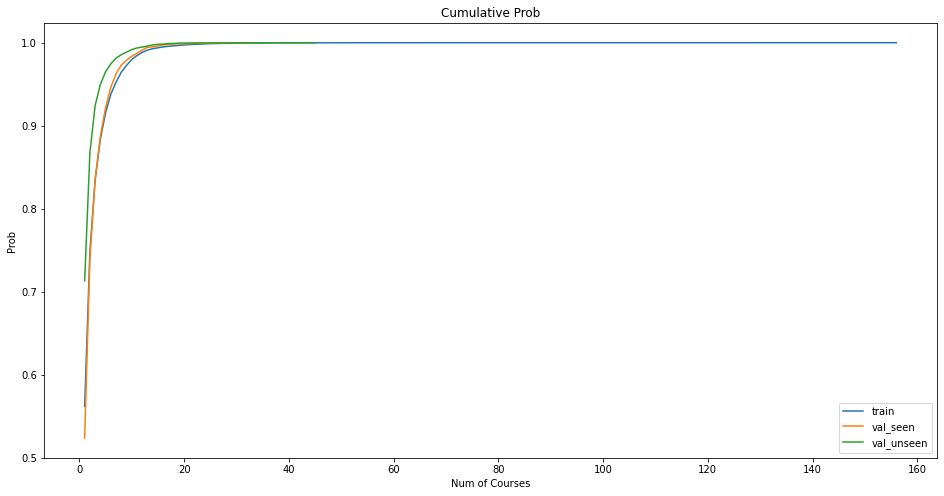

In [7]:

plt.figure(figsize=(16,8), facecolor='white')

for name, log in user_purchase_log.items():
    course_num = [ len(plog) for plog in log.values() ]
    total_purchase_count = sum(course_num)
    course_num = sorted(Counter(course_num).items())
    cprob = list_cumulative_prob(course_num)
    print(name)
    print("  ", cprob[0])
    print("  ", cprob[5])
    print("  ", cprob[10])
    print("  ", cprob[20])
    plt.plot(
        [ x for x, _ in cprob ],
        [ y for _, y in cprob ],
        label = name
    )
    plt.title("Cumulative Prob")
    plt.xlabel("Num of Courses")
    plt.ylabel("Prob")
    plt.legend()

plt.show()

1.0 0.47212183789365
2.0 0.6734641197728446
4.0 0.8526071244192049
8.0 0.9614093959731543


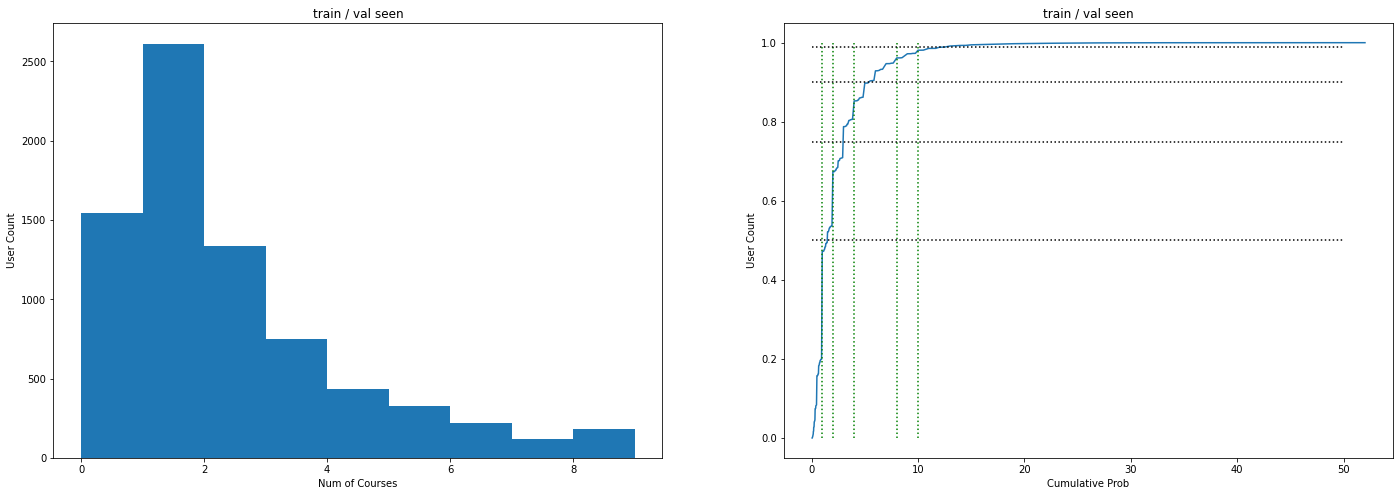

In [26]:
factors = []
for user in user_purchase_log['val_seen'].keys():
    factors.append(
        len(user_purchase_log['train'][user]) / len(user_purchase_log['val_seen'][user])
    )
prob = counter_cumulative_prob(Counter(factors))
# print(prob)


for x, p in prob:
    if x not in [1, 2, 4, 8]: continue
    print(x, p)

plt.figure(figsize=(24,8), facecolor='white')
plt.subplot(1,2,1)
plt.hist(
    factors,
    bins=np.arange(0, 10, 1)
)
plt.title( "train / val seen")
plt.xlabel("Num of Courses")
plt.ylabel("User Count")
plt.subplot(1,2,2)
plt.plot(
    [ x for x, _ in prob ],
    [ y for _, y in prob ]
)
plt.vlines(1, 0, 1, linestyles='dotted', colors='green')
plt.vlines(2, 0, 1, linestyles='dotted', colors='green')
plt.vlines(4, 0, 1, linestyles='dotted', colors='green')
plt.vlines(8, 0, 1, linestyles='dotted', colors='green')
plt.vlines(10, 0, 1, linestyles='dotted', colors='green')

plt.hlines(0.5, 0, 50, linestyles='dotted', colors='k')
plt.hlines(0.75, 0, 50, linestyles='dotted', colors='k')
plt.hlines(0.90, 0, 50, linestyles='dotted', colors='k')
plt.hlines(0.99, 0, 50, linestyles='dotted', colors='k')
plt.title( "train / val seen")
plt.xlabel("Cumulative Prob")
plt.ylabel("User Count")
plt.show()

҉唐鳳҉數...: 	6.15 %     0 $
Today...: 	4.41 %     0 $
2021 ...: 	4.27 %     0 $
Today...: 	3.67 %     0 $
遠距工作力...: 	3.14 %     0 $
Today...: 	2.96 %     0 $
Seaga...: 	2.83 %     0 $
Notio...: 	2.04 %  2680 $
Seaga...: 	1.57 %     0 $
Seaga...: 	1.44 %     0 $
   0 $: 	33.46 %
2400 $: 	3.49 %
1800 $: 	3.39 %
2800 $: 	3.03 %
2680 $: 	2.61 %
2500 $: 	2.40 %
1900 $: 	2.11 %
2600 $: 	2.04 %
2980 $: 	1.91 %
3600 $: 	1.86 %


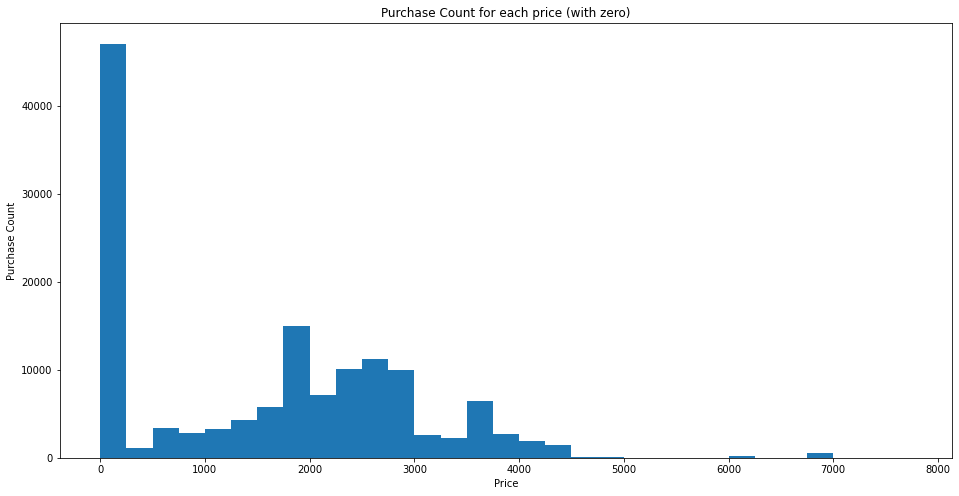

In [6]:
course_purchase = []
for plog in user_purchase_log['train'].values():
    course_purchase += plog
course_purchase = Counter(course_purchase)

total_purchase_count = np.sum( list(course_purchase.values()) )
topk_course = course_purchase.most_common(10)
for id, cnt in topk_course:
    print(f"{course_info[id]['course_name'][:5]}...: \t{cnt / total_purchase_count * 100:.2f} %  {course_info[id]['course_price']:4d} $" )

price_counter = {}
for id, cnt in course_purchase.items():
    price = course_info[id]['course_price']
    if price in price_counter:
        price_counter[price] += cnt
    else:
        price_counter[price] = cnt
price_counter = sorted( list(price_counter.items()), key=lambda x: (x[1], x[0]), reverse=True )
for price, cnt in price_counter[:10]:
    print(f"{price:4d} $: \t{cnt / total_purchase_count * 100:.2f} %" )

price_list = []
for price, cnt in price_counter:
    price_list += [price] * cnt

bins = list( range(0, 8000, 250) )
plt.figure(figsize=(16,8), facecolor='white')
plt.hist(price_list, bins=bins)
plt.title("Purchase Count for each price (with zero)")
plt.xlabel("Price")
plt.ylabel("Purchase Count")
plt.show()

# bins = list( range(0, 8000, 250) )
# plt.figure(figsize=(16,8), facecolor='white')
# plt.hist(price_list[price_counter[0][1]:], bins=bins)
# plt.title("Purchase Counte for each price (without zero)")
# plt.xlabel("Price")
# plt.ylabel("Purchase Count")
# plt.show()

建立個人品...: 	4.86 %     0 $
動態設計思...: 	4.34 %     0 $
我想離婚怎...: 	4.04 %     0 $
Today...: 	2.76 %     0 $
Today...: 	2.73 %     0 $
Today...: 	2.71 %     0 $
遠距工作力...: 	2.08 %     0 $
可愛先決！...: 	2.04 %  2999 $
風格藝術 ...: 	1.99 %  3200 $
Notio...: 	1.76 %  2680 $
   0 $: 	30.52 %
2500 $: 	3.75 %
1800 $: 	3.52 %
2680 $: 	3.43 %
2800 $: 	3.35 %
2980 $: 	3.13 %
3200 $: 	2.78 %
2400 $: 	2.45 %
2999 $: 	2.14 %
3600 $: 	1.94 %


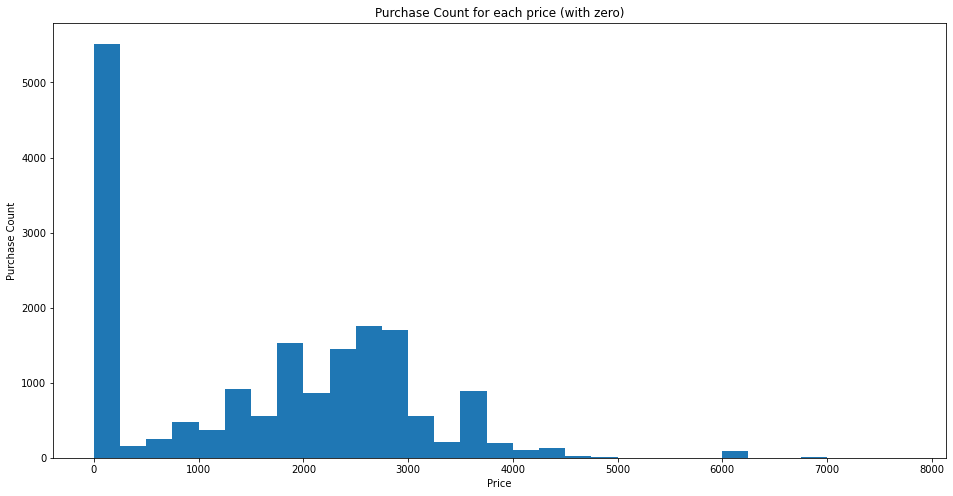

In [24]:
course_purchase = []
for plog in user_purchase_log['val_seen'].values():
    course_purchase += plog
course_purchase = Counter(course_purchase)

total_purchase_count = np.sum( list(course_purchase.values()) )
topk_course = course_purchase.most_common(10)
for id, cnt in topk_course:
    print(f"{course_info[id]['course_name'][:5]}...: \t{cnt / total_purchase_count * 100:.2f} %  {course_info[id]['course_price']:4d} $" )

price_counter = {}
for id, cnt in course_purchase.items():
    price = course_info[id]['course_price']
    if price in price_counter:
        price_counter[price] += cnt
    else:
        price_counter[price] = cnt
price_counter = sorted( list(price_counter.items()), key=lambda x: (x[1], x[0]), reverse=True )
for price, cnt in price_counter[:10]:
    print(f"{price:4d} $: \t{cnt / total_purchase_count * 100:.2f} %" )

price_list = []
for price, cnt in price_counter:
    price_list += [price] * cnt

bins = list( range(0, 8000, 250) )
plt.figure(figsize=(16,8), facecolor='white')
plt.hist(price_list, bins=bins)
plt.title("Purchase Count for each price (with zero)")
plt.xlabel("Price")
plt.ylabel("Purchase Count")
plt.show()

# bins = list( range(0, 8000, 250) )
# plt.figure(figsize=(16,8), facecolor='white')
# plt.hist(price_list[price_counter[0][1]:], bins=bins)
# plt.title("Purchase Counte for each price (without zero)")
# plt.xlabel("Price")
# plt.ylabel("Purchase Count")
# plt.show()

train
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 87, 220, 0, 0, 0, 0, 0, 0, 0, 0, 0, 162, 483, 644, 0, 0, 0, 0, 0, 0, 0, 0, 0, 652, 1047, 1129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1600, 716, 783, 0, 0, 0, 0, 0, 0, 0, 0, 0, 564, 1039, 601, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2693, 17536, 14354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2669, 595, 0] ['2015-1', '2015-2', '2015-3', '2015-4', '2015-5', '2015-6', '2015-7', '2015-8', '2015-9', '2015-10', '2015-11', '2015-12', '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6', '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8', '2017-9', '2017-10', '2017-11', '2017-12', '2018-1', '2018-2', '2018-3', '2018-4', '2018-5', '2018-6', '2018-7', '2018-8', '2018-9', '2018-10', '2018-11', '2018-12', '2019-1', '2019-2', '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', '2019-10', '2019-11', '2019-12', '2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8'

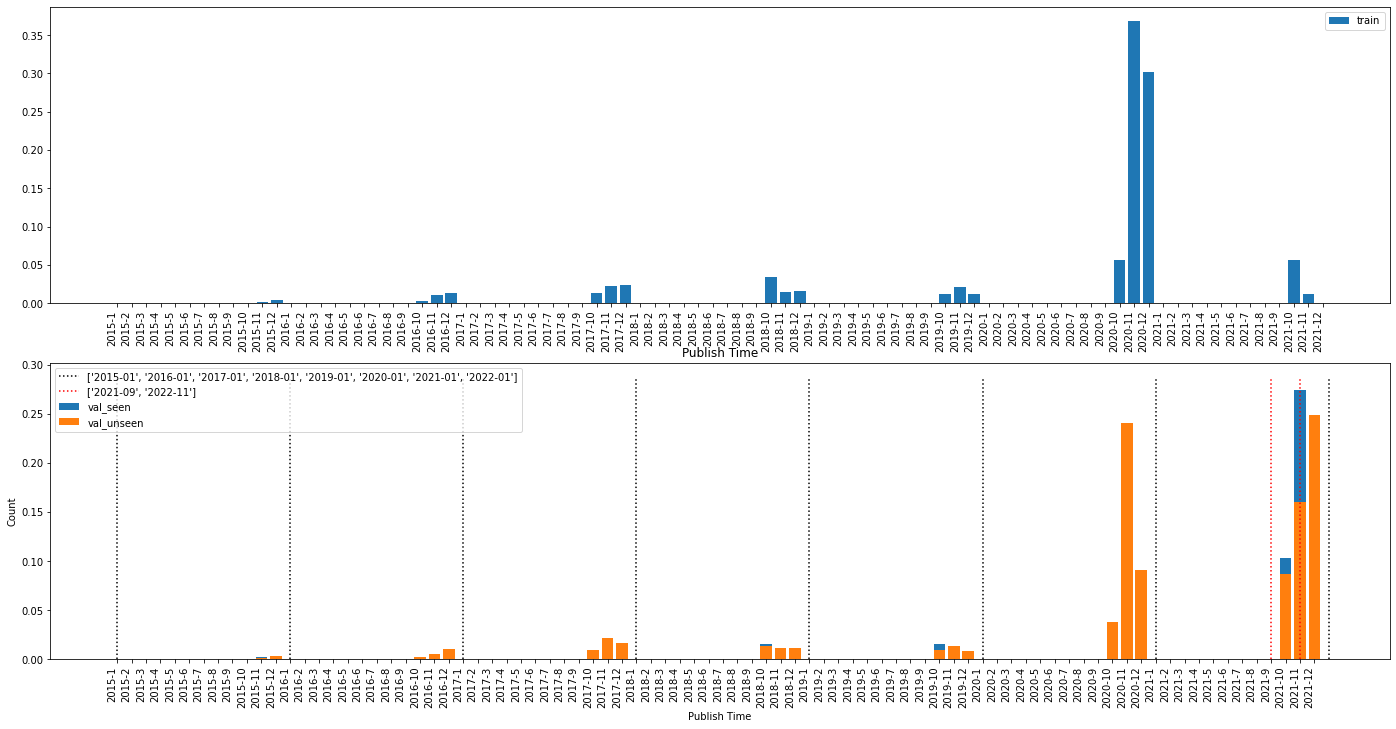

In [32]:

plt.figure(figsize=(24,12), facecolor='white')


for name, log in user_purchase_log.items():
    print(name)
    pubtime_cnt = []
    for plog in log.values():
        for id in plog:
            t = course_info[id]['course_published_at_local'][:7]
            pubtime_cnt.append( t )

    pubtime_cnt = Counter(pubtime_cnt)
    pubtime = []
    cnt = []
    for year in range(2015, 2022):
        for month in range(1, 13):
            t = f"{year}-{month}"
            pubtime.append(t)
            cnt.append(pubtime_cnt[t])
    print(cnt, pubtime)
    total = np.sum(cnt)
    if name == 'train':
        plt.subplot(2,1,1)
    else:
        plt.subplot(2,1,2)
    plt.bar(
        x=pubtime,
        height=[ y/total for y in cnt ],
        label=name,
        alpha=0.6,
    )
    plt.xticks(rotation=90, ha='right')
    plt.legend()


num_years = 8
ymin, ymax = plt.ylim()
plt.vlines(
    x    = [ i * 12 for i in range(num_years) ],
    ymin = [ ymin ] * num_years,
    ymax = [ ymax ] * num_years,
    label = [ f'{2015+i}-01' for i in range(num_years) ],
    colors = [ 'k' ] * num_years,
    linestyles = ['dotted'] * num_years,
)

plt.vlines(
    x    = [ (2021-2015) * 12 + 8, (2021-2015) * 12 + 10 ],
    ymin = [ ymin ] * 2,
    ymax = [ ymax ] * 2,
    label = [ '2021-09', '2022-11'],
    colors = [ 'red' ] * 2,
    linestyles = ['dotted'] * 2,
)

plt.title("Publish Time")
plt.xlabel("Publish Time")
plt.ylabel("Count")
plt.legend()
plt.show()

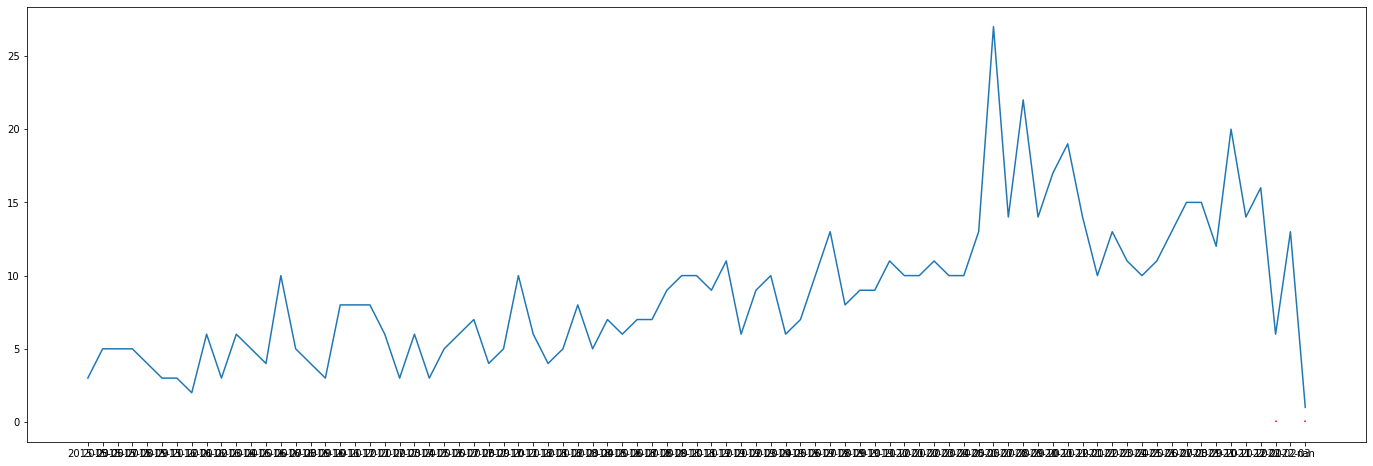

[('2015-03', 3), ('2015-05', 5), ('2015-07', 5), ('2015-08', 5), ('2015-09', 4), ('2015-11', 3), ('2015-12', 3), ('2016-01', 2), ('2016-02', 6), ('2016-03', 3), ('2016-04', 6), ('2016-05', 5), ('2016-06', 4), ('2016-07', 10), ('2016-08', 5), ('2016-09', 4), ('2016-10', 3), ('2016-11', 8), ('2016-12', 8), ('2017-01', 8), ('2017-02', 6), ('2017-03', 3), ('2017-04', 6), ('2017-05', 3), ('2017-06', 5), ('2017-07', 6), ('2017-08', 7), ('2017-09', 4), ('2017-10', 5), ('2017-11', 10), ('2017-12', 6), ('2018-01', 4), ('2018-02', 5), ('2018-03', 8), ('2018-04', 5), ('2018-05', 7), ('2018-06', 6), ('2018-07', 7), ('2018-08', 7), ('2018-09', 9), ('2018-10', 10), ('2018-11', 10), ('2018-12', 9), ('2019-01', 11), ('2019-02', 6), ('2019-03', 9), ('2019-04', 10), ('2019-05', 6), ('2019-06', 7), ('2019-07', 10), ('2019-08', 13), ('2019-09', 8), ('2019-10', 9), ('2019-11', 9), ('2019-12', 11), ('2020-01', 10), ('2020-02', 10), ('2020-03', 11), ('2020-04', 10), ('2020-05', 10), ('2020-06', 13), ('2020-0

In [16]:
time = []
for course in course_info.values():
    t = course['course_published_at_local']
    if type(t) == str:
        t = t[:7]
    else:
        t = str(t)
    time.append(t)

time = sorted(Counter(time).items())

plt.figure(figsize=(24,8), facecolor='white')
plt.plot(
    [ x for x, _ in time ],
    [ y for _, y in time ],
)
plt.vlines(
    x    = [ (2021-2015) * 12 + 8, (2021-2015) * 12 + 10 ],
    ymin = [ 0 ] * 2,
    ymax = [ 0.15 ] * 2,
    label = [ '2021-09-01', '2022-11-01'],
    colors = [ 'red' ] * 2,
    linestyles = ['dotted'] * 2,
)
plt.show()
print(time)

## Course Chapter Items

In [6]:
def course_chapter_feature():
    item_file = "../data/course_chapter_items.csv"
    df = pd.read_csv(item_file)
    
    feature = {
        "course_id": [],
        "chapter_cnt": [],
        "unit_cnt": [],
        "assignment_cnt": [],
        "total_sec": [],
    }

    for course_id, sub_df in df.groupby("course_id"):
        chapter_no = np.max(sub_df['chapter_no'])
        unit_cnt = np.sum( sub_df['chapter_item_type'] == "LECTURE" )
        assignment_cnt = np.sum( sub_df['chapter_item_type'] == "ASSIGNMENT" )
        total_sec = np.sum( sub_df['video_length_in_seconds'].fillna(0) )

        assert( unit_cnt + assignment_cnt == len(sub_df) )

        feature['course_id'].append( course_id )
        feature['chapter_cnt'].append( chapter_no )
        feature['unit_cnt'].append( unit_cnt )
        feature['assignment_cnt'].append( assignment_cnt )
        feature['total_sec'].append( total_sec )

    new_df = pd.DataFrame.from_dict(feature)
    return new_df

In [7]:
course_purchase = []
for plog in user_purchase_log['train'].values():
    course_purchase += plog
course_purchase = Counter(course_purchase)

course_items_df = course_chapter_feature()
course_items_df.head()

course_items_df['purchase_cnt'] = [ course_purchase[id] for id in course_items_df['course_id']]
course_items_df.head()

,course_id,chapter_cnt,unit_cnt,assignment_cnt,total_sec,purchase_cnt
0,54d5a117065a7e0e00725ac0,1,3,1,1839.0,60
1,54d5d9952246e60a009ec571,1,6,1,3478.0,11
2,54d7148a2246e60a009ec588,1,7,1,3919.0,55
3,54f1268f4ec3c809002e4a29,1,18,1,2578.0,23
4,551171a938239d1000577864,1,9,1,7438.0,13


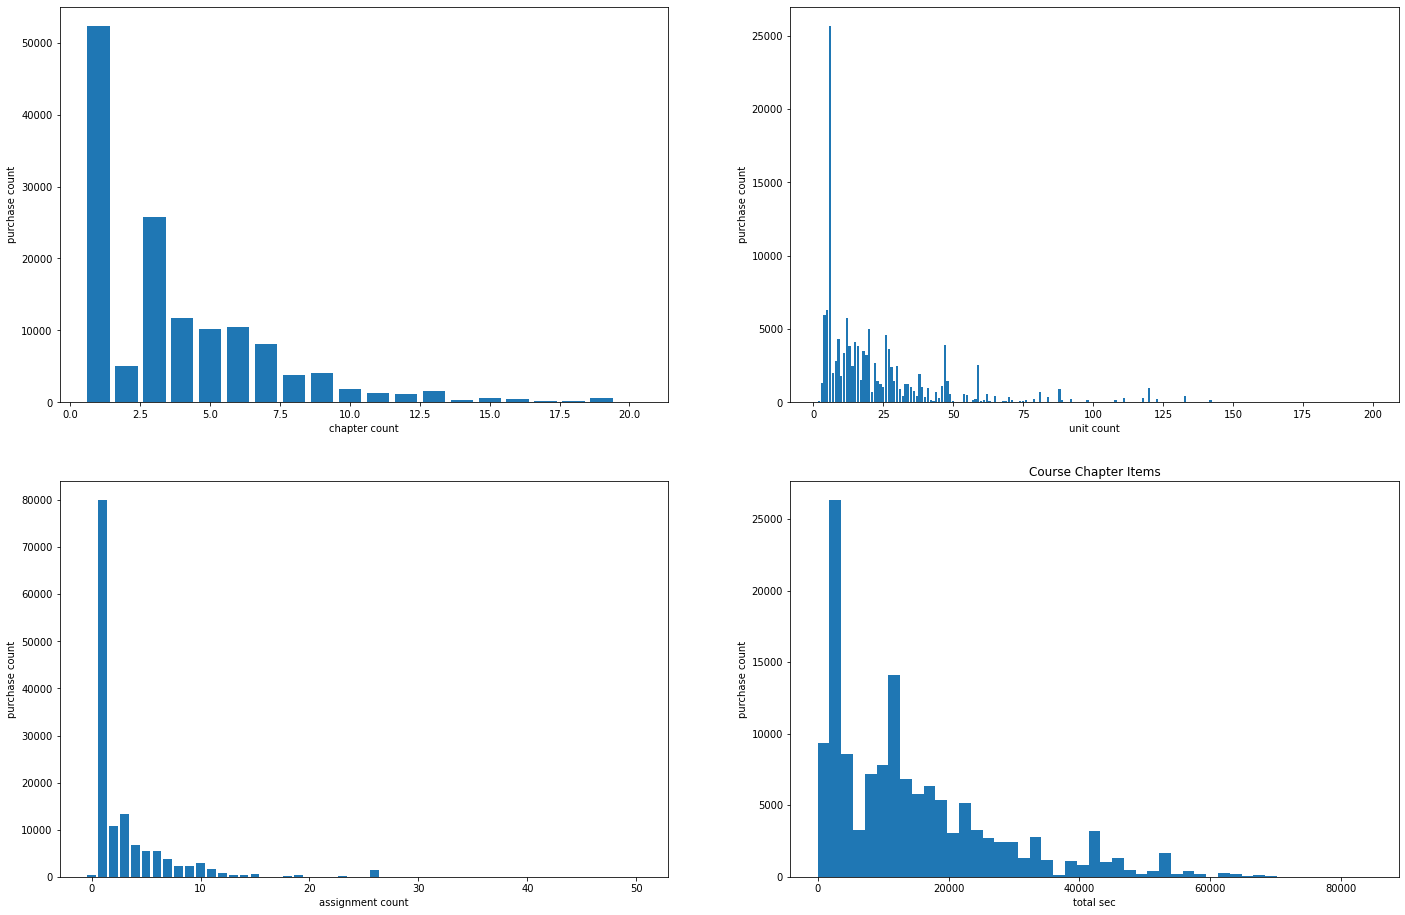

In [20]:
plt.figure(figsize=(24,16), facecolor='white')

feat_names = ['chapter_cnt', 'unit_cnt', 'assignment_cnt' ]
target_name = 'purchase_cnt'

for i, feat_name in enumerate(feat_names):
    x, y = [], []
    for feat, sub_df in course_items_df.groupby(feat_name):
        x.append(feat)
        y.append(np.sum(sub_df[target_name]))

    plt.subplot(2,2,i+1)
    plt.bar(x, y)
    plt.xlabel( feat_name.replace("_cnt", " count"))
    plt.ylabel("purchase count")


for feat_name in ['total_sec']:
    x = []
    for feat, sub_df in course_items_df.groupby(feat_name):
        x += [feat] * np.sum(sub_df[target_name])

    plt.subplot(2,2,4)
    min = 60
    hour = min * 60
    plt.hist(x, bins=range(0, 24*hour, 30*min))
    plt.xlabel( feat_name.replace("_", " "))
    plt.ylabel("purchase count")

plt.title("Course Chapter Items")
plt.show()

# Group Analysis
1. 偏好的 Group
    + 整體偏好: $P(group)$
    + 個人偏好: $P(group | user)$


In [20]:
user_subgroups = {}
user_subgroups['train'] = read_log_or_subgroup("../data/train_group.csv")
user_subgroups['val_seen'] = read_log_or_subgroup("../data/val_seen_group.csv")
user_subgroups['val_unseen'] = read_log_or_subgroup("../data/val_unseen_group.csv")

subgroups_info = read_csv_as_dict("../data/subgroups.csv")

In [26]:
IoU = []
IoG = []
for id in user_subgroups['val_seen'].keys():
    S1 = set(user_subgroups['train'][id])
    S2 = set(user_subgroups['val_seen'][id])
    I = len(S1 & S2)
    U = len(S1 | S2)
    if U == 0:
        IoU.append( -1 )
    else:
        IoU.append( I / U )
    if len(S2) == 0:
        IoG.append( -1 )
    else:
        IoG.append( I / len(S2) )


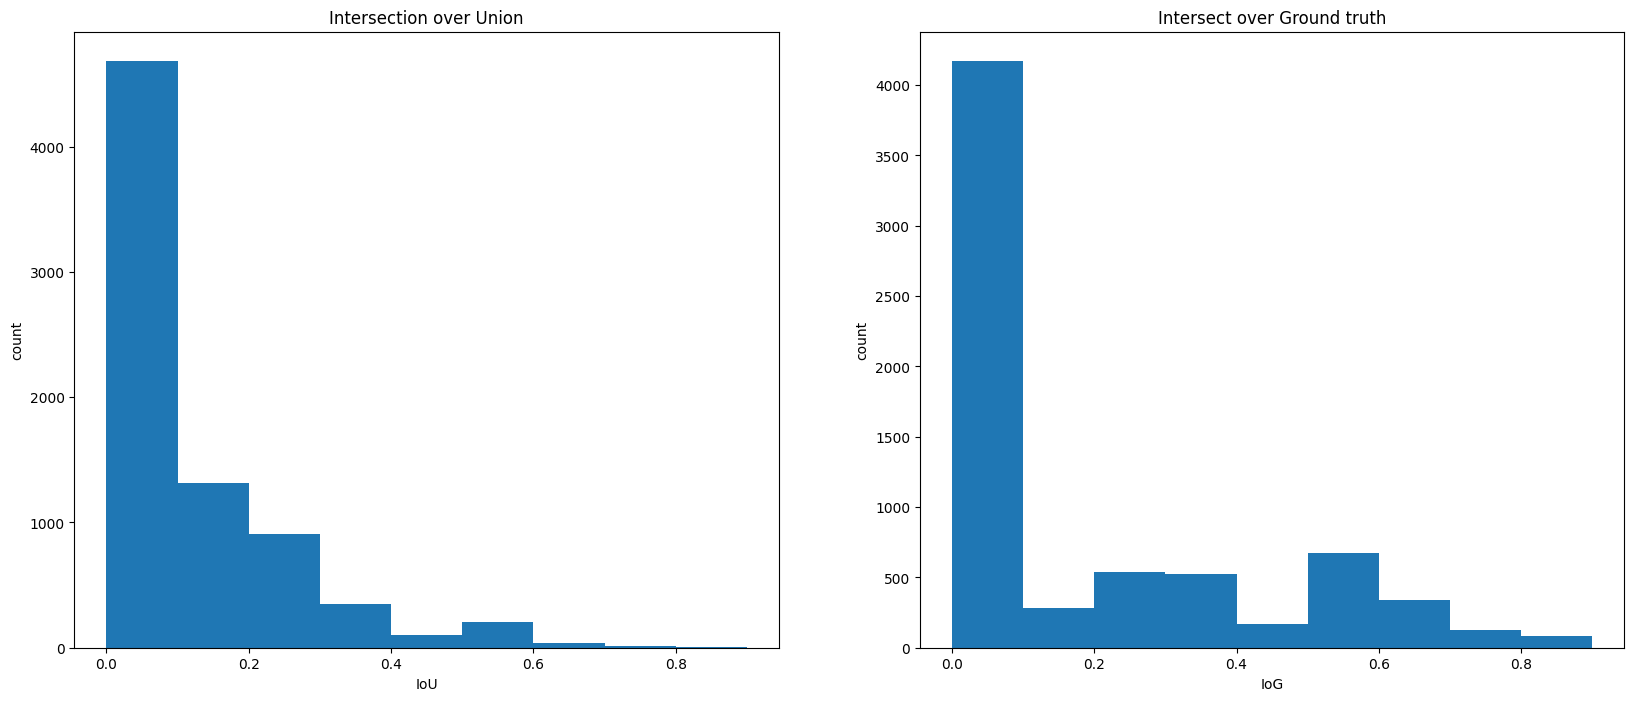

In [61]:
plt.figure(figsize=(20,8), facecolor='white')

plt.subplot(1,2,1)
plt.hist(
    IoU,
    bins=np.arange(0, 1.0, 0.1)
)
plt.ylabel("count")
plt.xlabel("IoU")
plt.title("Intersection over Union")

plt.subplot(1,2,2)
plt.hist(
    IoG,
    bins=np.arange(0, 1.0, 0.1)
)
plt.ylabel("count")
plt.xlabel("IoG")
plt.title("Intersect over Ground truth")
plt.show()


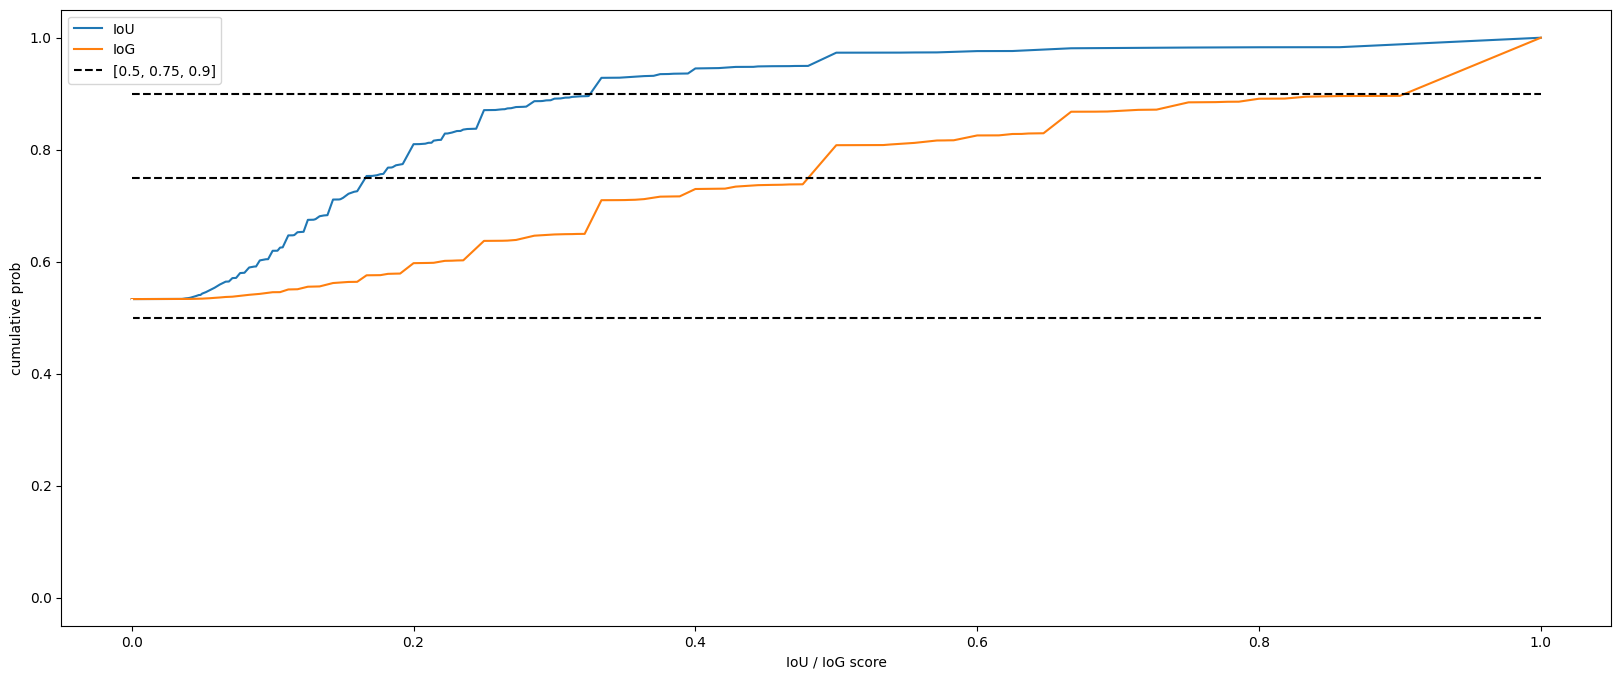

In [57]:
cprob_IoU = counter_cumulative_prob( Counter(IoU) )
cprob_IoU = cprob_IoU[1:]
plt.figure(figsize=(20,8), facecolor='white')
plt.plot(
    [x for x, _ in cprob_IoU],
    [y for _, y in cprob_IoU],
    label = 'IoU',
)


cprob_IoG = counter_cumulative_prob( Counter(IoG) )
cprob_IoG = cprob_IoG[1:]
plt.plot(
    [x for x, _ in cprob_IoG],
    [y for _, y in cprob_IoG],
    label = 'IoG',
)
plt.hlines(
    y = [0.5, 0.75, 0.9],
    xmin = [0.0, 0.0, 0.0],
    xmax = [1.0, 1.0, 1.0],
    colors = ['k'] * 3,
    linestyles = 'dashed',
    label = [0.5, 0.75, 0.9]
)
plt.vlines(
    x = 0.0,
    ymin = 0.0,
    ymax = max(cprob_IoG[0][1], cprob_IoU[0][1]),
    colors = 'white'
)
plt.xlabel('IoU / IoG score')
plt.ylabel('cumulative prob')
plt.legend()
plt.show()